Ova skripta sluzi da sprovedemo novu (nadamo se poboljsanu) strategiju balansiranja

Prosla strategija je podrazumevala sledece:
1. Podela podataka na klase koje su predstavljene tonom koze
2. Prikaz broja podataka po klasama preko bar plota
3. Uklanjanje jedne od klasa koja je sadrzala ukupno 6 pacijenata
4. Undersampling klasa ciji je broj benignih podataka bio veci od 1000
5. Augmentacija klasa ciji je broj benignih podataka bio manji od 1000
6. Augmentacija svih malignih podataka

Kao rezultat ove strategije balansiranja dobije se sledece:
1. 7864 benignih podataka
2. 1426 malignih podataka
3. Odnos priblizno 1:5

U ovoj strategiji cilj ce biti da odnos bude 1:4

In [1]:
import pandas as pd
from notebooks.exploration.plot_utils import plot_skin_tone_distribution_v2

In [2]:
df = pd.read_csv("ocisceni_podaci_sa_tonom_koze_kopija.csv")

In [3]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,skin_tone
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,#F3E7DB
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,#D7BD96
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,#604134
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,#604134
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,#D7BD96


In [4]:
print(len(df))

32531


Kao i prosli put, na pocetku imamo 32531 podatak, od koji su 575 maligni, a 31956 benigni

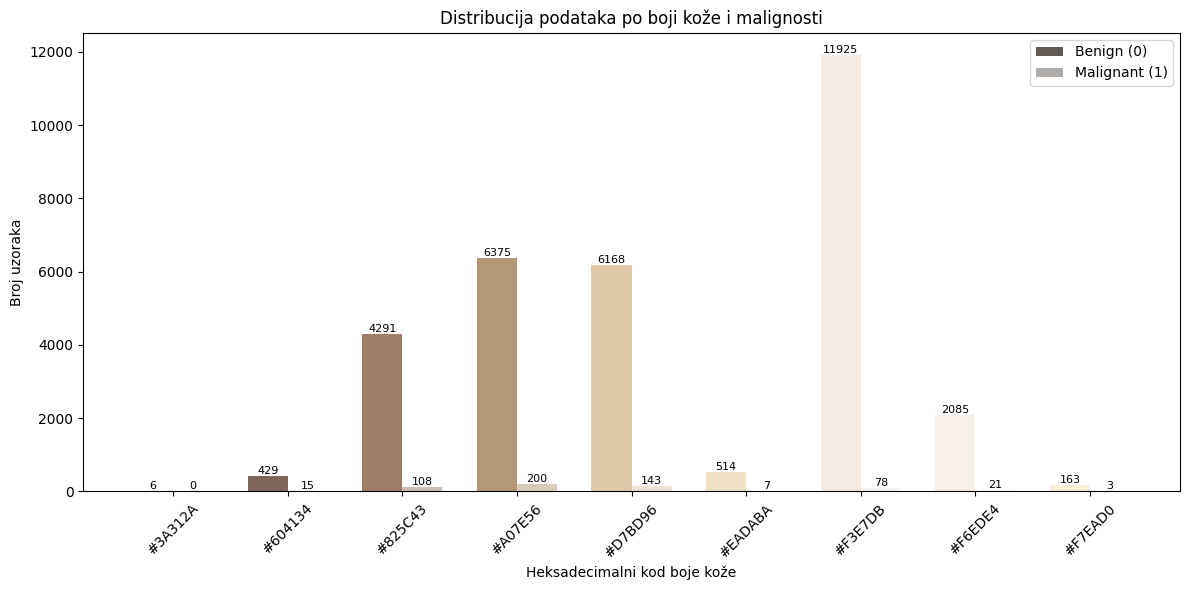

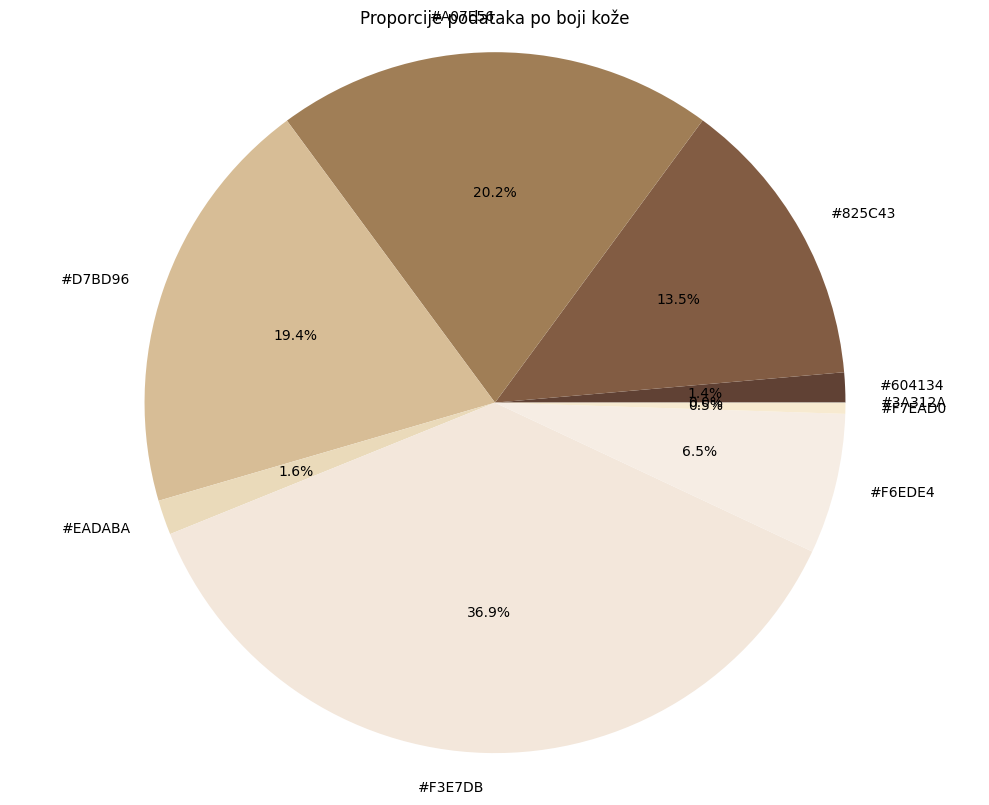

In [5]:
plot_skin_tone_distribution_v2(df)

Ponovo je potrebno izbaciti klasu koja ima 6 podataka

In [6]:
#izbacujemo klasu #3A312A
df = df[df['skin_tone'] != '#3A312A']

In [7]:
#provera
print(len(df))

32525


Treba razdvojiti benigne i maligne podatke kako bismo mogli posebno da radimo sa njima

In [8]:
# Razdvajamo benigne i maligne
benign_df = df[df['target'] == 0]
malignant_df = df[df['target'] == 1]

Posto zelimo da postignemo odnos 1:4, a imamo ukupno 8 klasa, cilj ce biti da benignih podataka bude 4000 (500 u svakoj klasi) i da malignih bude 1000 (100-125 u svakoj klasi)

Sada treba undersamplovati benigne podatke u klasama gde ih ima vise od 500

In [9]:
#u ovoj celiji cemo odstraniti visak podataka u klasama koje imaju vise od 1100 benignih predstavnika
# Grupisanje benignih po skin_tone i uzimanje do 1100 nasumično po grupi
benign_df = (
    benign_df.groupby('skin_tone')
    .apply(lambda x: x.sample(n=500, random_state=42) if len(x) > 500 else x)
    .reset_index(drop=True)
)

C:\Users\Marko\AppData\Local\Temp\ipykernel_5028\4022475560.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=500, random_state=42) if len(x) > 500 else x)


In [10]:
#provera
print(benign_df['skin_tone'].value_counts())

skin_tone
#825C43    500
#A07E56    500
#D7BD96    500
#EADABA    500
#F6EDE4    500
#F3E7DB    500
#604134    429
#F7EAD0    163
Name: count, dtype: int64


In [11]:
import sys
import os
sys.path.append('scripts')
from Augmentacija import Augmentation
from augmentacija_funkcija import augment_images

In [12]:
#Ucitavanje dataset-a sa slikama
data_dir = 'C:/Users/Marko/MELANOMA/ISIC_2020_Training_JPEG/train'
os.listdir(data_dir)[0]

'aug_ISIC_0052212_0.jpg'

In [13]:
#instanca klase Augmentation
augment = Augmentation()

In [14]:
#lista mogucih augmentacija slika
augmentation_functions = [
    augment.brightness,
    augment.contrast,
    augment.color_jitter,
    augment.gaussian_noise,
    augment.blur,
    augment.crop_resize,
    augment.zoom,
]

Sada je potrebno augmentovati benigne podatke iz 2 klase, #604134 (429 podatka) i #F7EAD0 (163 podatka)

Iz prve klase cemo da odaberemo 71 podatak za augmentaciju

In [15]:
df_604134 = df[(df['skin_tone'] == '#604134') & (df['target'] == 0)]
random_indexes = df_604134.sample(n=71, random_state=42).index
df_604134_to_augment = df.loc[random_indexes]

In [16]:
#provera
print(len(df_604134_to_augment))

71


In [17]:
# Izvlacimo listu naziva fajlova slika iz DataFrame-a za augmentaciju
images_604134_to_augment = df_604134_to_augment['image_name'].tolist()

In [18]:
#poziv funckije augment_images
benign_df = augment_images(
    df = benign_df,
    data_dir= data_dir,
    num_generated_per_image=1,
    images_to_augment=images_604134_to_augment,
    augmentations=augmentation_functions
)

In [19]:
#provera
print(benign_df['skin_tone'].value_counts())

skin_tone
#604134    500
#825C43    500
#A07E56    500
#D7BD96    500
#EADABA    500
#F3E7DB    500
#F6EDE4    500
#F7EAD0    163
Name: count, dtype: int64


Iz druge klase cemo da odaberemo svih 163 podatka i augmentovacemo 3 puta (163*3=489)

In [20]:
df_F7EAD0_to_augment = df[(df['skin_tone'] == '#F7EAD0') & (df['target'] == 0)]

In [21]:
#provera
print(len(df_F7EAD0_to_augment))

163


In [22]:
images_F7EAD0_to_augment = df_F7EAD0_to_augment['image_name'].tolist()

In [23]:
#poziv funckije augment_images
benign_df = augment_images(
    df = benign_df,
    data_dir= data_dir,
    num_generated_per_image=2,
    images_to_augment=images_F7EAD0_to_augment,
    augmentations=augmentation_functions
)

In [24]:
#provera
print(benign_df['skin_tone'].value_counts())

skin_tone
#604134    500
#825C43    500
#A07E56    500
#D7BD96    500
#EADABA    500
#F3E7DB    500
#F6EDE4    500
#F7EAD0    489
Name: count, dtype: int64


Ovim je zavrsen posao vezan za benigne podatke, ostaju jos maligni

In [25]:
print(malignant_df['skin_tone'].value_counts())

skin_tone
#A07E56    200
#D7BD96    143
#825C43    108
#F3E7DB     78
#F6EDE4     21
#604134     15
#EADABA      7
#F7EAD0      3
Name: count, dtype: int64


Poslednje 4 kolone (4 sa najmanje podataka) treba augmentovati maksimalan broj puta

In [26]:
#spajamo poslednje 4 klase u jedan df
malignant_df_to_augment = malignant_df[(malignant_df['skin_tone'] == '#F6EDE4') | (malignant_df['skin_tone'] == '#604134') | (malignant_df['skin_tone'] == '#EADABA') | (malignant_df['skin_tone'] == '#F7EAD0')]

In [27]:
#provera
print(malignant_df_to_augment['skin_tone'].value_counts())

skin_tone
#F6EDE4    21
#604134    15
#EADABA     7
#F7EAD0     3
Name: count, dtype: int64


In [28]:
# Izvlacimo listu naziva fajlova slika iz DataFrame-a za augmentaciju
malignant_images_to_augment = malignant_df_to_augment['image_name'].tolist()

In [29]:
#poziv funckije augment_images
malignant_df = augment_images(
    df = malignant_df,
    data_dir= data_dir,
    num_generated_per_image=7,
    images_to_augment=malignant_images_to_augment,
    augmentations=augmentation_functions
)

In [30]:
#provera
print(malignant_df['skin_tone'].value_counts())

skin_tone
#A07E56    200
#F6EDE4    168
#D7BD96    143
#604134    120
#825C43    108
#F3E7DB     78
#EADABA     56
#F7EAD0     24
Name: count, dtype: int64


Prve tri klase iz prvobitnog poretka (#A07E56, #F6EDE4 i #825C43) necemo augmentovati jer imaju dovoljno malignih podataka

Ostaje jos samo da ugmentujemo polovinu klase #F3E7DB (78 podataka)

In [36]:
df_F3E7DB = df[(df['skin_tone'] == '#F3E7DB') & (df['target'] == 1)]
random_indexes = df_F3E7DB.sample(39, random_state=42).index
df_F3E7DB_to_augment = df.loc[random_indexes]

In [37]:
#provera
print(len(df_F3E7DB_to_augment))

39


In [38]:
images_F3E7DB_to_augment = df_F3E7DB_to_augment['image_name'].tolist()

In [39]:
#poziv funckije augment_images
malignant_df = augment_images(
    df = malignant_df,
    data_dir= data_dir,
    num_generated_per_image=1,
    images_to_augment=images_F3E7DB_to_augment,
    augmentations=augmentation_functions
)

In [40]:
print(malignant_df['skin_tone'].value_counts())

skin_tone
#A07E56    200
#F6EDE4    168
#D7BD96    143
#604134    120
#F3E7DB    117
#825C43    108
#EADABA     56
#F7EAD0     24
Name: count, dtype: int64


Ovim postupkom je dobijeno 936 malignih podataka i 3989 benignih podataka; odnos je priblizno 1:4

In [41]:
#konkatenacija stringova u originalni df
df = pd.concat([benign_df, malignant_df], ignore_index=True)

In [42]:
#provera
print(len(df))

4925


In [43]:
#Cuvanje ažuriranog DataFrame-a u novi CSV fajl
df.to_csv('balansirani_podaci_2.csv', index=False)